In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d

import pandas as pd
import math
import copy
import pickle
from keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import BatchNormalization, Layer, TimeDistributed, Dropout
from keras.layers import Dense, Input, Masking, LSTM
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from sklearn.metrics import mean_squared_error

C:\Users\Greg\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Greg\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Greg\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Greg\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:5

In [2]:
import RNNJF

## Data Loading and Pre-Processing

Let's start by trying to load in our toy jets, and then separate into features (to train on) and labels (to predict).

For features, first try d0, z0, phi, theta, qOverP, (refPx, refPy, refPz)?. Essentially the track parameters.

For labels, Xs, Ys, Zs, Xt, Yt, Zt. That is the secondary and tertiary vertices. Omit the primary as this has been fixed to (0,0,0). This will require some smart selection for c and light jets, where not all vertices are present. If a vertex is not present, could try predicting (0,0,0) or (-1,-1,-1) or previous vertex (prim or sec).

In [3]:
bjets_DF = pd.read_pickle("./bjets_newminerrs.pkl")#./bjets_IPonly_abs_10um_errs.pkl")
#cjets_DF = pd.read_pickle("./cjets.pkl")
#ljets_DF = pd.read_pickle("./ljets.pkl")

In [4]:
def load_data(DF, remove_dirtrack, add_dirtrack, features=['d0', 'z0', 'phi', 'theta', 'q/p']):
    order_by_feature = None
    use_custom_order = 't1'
    reverse=True
    no_reorder=False
    all_features = np.array(['d0', 'z0', 'phi', 'theta', 'q/p', 'x_o', 'y_o', 'z_o', 'x_p', 'y_p', 'z_p'])
    print("reading the datafile")
    bjets_DF = pd.read_pickle(DF)  # "./bjets_IPonly_abs_10um_errs.pkl")
    print("loading tracks")
    X = RNNJF.get_tracks(bjets_DF)
    print("preprocessing the data")
    if remove_dirtrack: X = RNNJF.remove_direction_track(X, len(features))
    nodirtrack = remove_dirtrack or not add_dirtrack
    if order_by_feature is not None:
        if reverse:
            print("ordering by decreasing {}".format(order_by_feature))
        else:
            print("ordering by increasing {}".format(order_by_feature))
        fidx = np.where(all_features == order_by_feature)[0][0]
        X = RNNJF.order_by_feature(X, nodirtrack, reverse, feature=fidx)
    elif use_custom_order is not None:
        if use_custom_order == 'r0':
            print("using custom ordering: by sqrt(d0^2 +z0^2)")
            X = RNNJF.order_by_r0(X, nodirtrack, reverse)
        elif use_custom_order == 't1':
            print("using custom ordering: by t1")
            X = RNNJF.order_by_t1(X, nodirtrack, reverse)
        else:
            raise NotImplemented("custom ordering with {} not implemented".format(args.use_custom_order))
    elif no_reorder:
        print("No reorder performed")
    else:
        print("using random order")
        X = RNNJF.order_random(X)
    
    X_allfeatures = copy.copy(X)
    X = RNNJF.only_keep_features(X, features)
    robust_features=['d0','z0','q/p','x_p','y_p']
    X = RNNJF.scale_features(X, features, robust_features=robust_features)
    X = np.nan_to_num(X)
    y = bjets_DF[['secVtx_x', 'secVtx_y', 'secVtx_z', 'terVtx_x', 'terVtx_y', 'terVtx_z']].values
    y = y * 1000  # change units of vertices from m to mm, keep vals close to unity
    return X, y, X_allfeatures


In [5]:
datafile = "./bjets_newminerrs.pkl"
if "new" in datafile:
    remove_dirtrack = False
    # option to add dirtrack using jet information
    add_dirtrack = False
else:
    remove_dirtrack = True
    # add_dirtrack = False

features = ['d0', 'z0', 'phi', 'theta', 'q/p','x_p','y_p']
X, y, X_allfeatures = load_data(datafile,remove_dirtrack,add_dirtrack,features=features)
X_train, X_test, y_train, y_test = RNNJF.split_train_test(X, y,split=280000, seed=4)

reading the datafile
loading tracks
preprocessing the data
using custom ordering: by t1
no direction track, ordering by closest distance along jet axis
Robust Scaling: d0
Robust Scaling: z0
MinMax Scaling: phi
MinMax Scaling: theta
Robust Scaling: q/p
Robust Scaling: x_p
Robust Scaling: y_p
train/test split with seed 4
(280000, 30, 7)


In [6]:
X = RNNJF.get_tracks(bjets_DF)


Extract the track parameters as our features

In [7]:
features = ['d0','z0','phi','theta','q/p','x_p','y_p']
trks = RNNJF.get_tracks(bjets_DF,features)

TypeError: get_tracks() takes 1 positional argument but 2 were given

In [8]:
X = trks # following convention name the features as the vector 'X'

NameError: name 'trks' is not defined

d0
median is  0.0003185399934682131


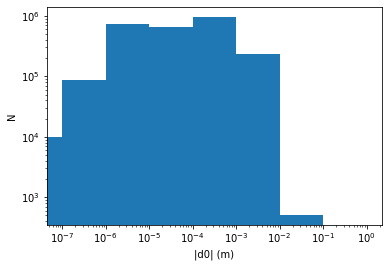

z0
median is  0.0002344404838608026


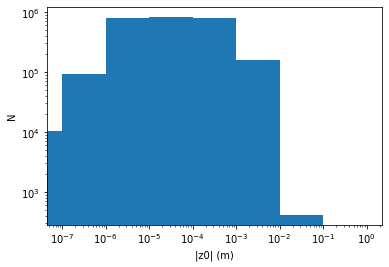

phi
median is  0.7992352908351905


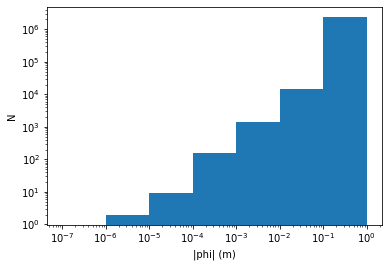

theta
median is  0.8393435372325055


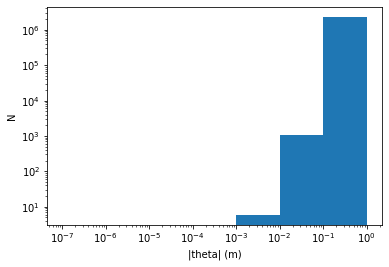

q/p
median is  0.0006373915852437133


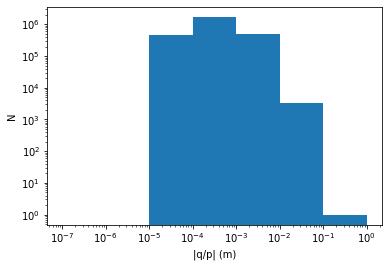

In [10]:
for var in range(5):
    print(features[var])
    trackvar = copy.copy(X[:,:,var])
    trackvar = trackvar[~np.isnan(trackvar)]
    print("median is ",np.mean(abs(trackvar)))
    binss=np.linspace(np.min(trackvar),np.max(trackvar),1000)
#     if features[var] == 'z0': 
    binss = np.array([0,0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,1])
    plt.hist(abs(trackvar),bins=binss,log=True)
    plt.xscale('log')
    plt.ylabel("N")
    plt.xlabel("|{}| (m)".format(features[var]))
    plt.savefig("toyjets_logscale_{}_distribitons.png".format(features[var])) if features[var] != "q/p" else plt.savefig("toyjets_logscale_{}_distribitons.png".format("qp"))
    plt.show()

z0
median is  0.0002344404838608026


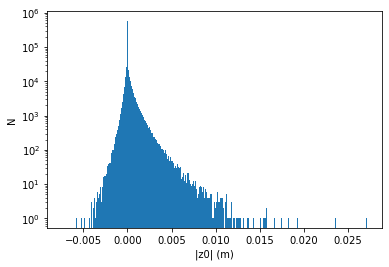

In [15]:
for var in [1]:
    print(features[var])
    trackvar = copy.copy(X[:,:,var])
    trackvar = trackvar[~np.isnan(trackvar)]
    print("median is ",np.mean(abs(trackvar)))
    binss=np.linspace(np.min(trackvar),np.max(trackvar),1000)
#     if features[var] == 'z0': 
    binss = 'scott'
    plt.hist(trackvar,bins=binss,log=True)
#     plt.xscale('log')
    plt.ylabel("N")
    plt.xlabel("|{}| (m)".format(features[var]))
    plt.savefig("toyjets_{}_distribitons.png".format(features[var])) if features[var] != "q/p" else plt.savefig("toyjets_logscale_{}_distribitons.png".format("qp"))
    plt.show()

In [17]:
np.isnan(trackvar)

array([False, False, False, ...,  True,  True,  True])

### Track Ordering

Use numpy sort function should work, order in descending value say of impact parameter or something (shouldnt be any negatives)

Maybe want to move this section and order later, after normalization

In [ ]:
def t1(rp,d2):
    d1 = 0.5*np.array([1,1,np.sqrt(2)])
    if np.all(d1 == d2):
        print("parallel lines!")
        return 0
    numerator=np.multiply(rp,d1-(np.dot(d2,d1).reshape(-1,1)*d2)).sum(1).reshape(-1,1)
    denominator=(1- np.dot(d2,d1).reshape(-1,1)**2)
    t1 = numerator/denominator
    return t1.reshape(-1)
    

In [ ]:
%%time
Xordered = copy.copy(X)#

for i,jet in enumerate(Xordered[:,0:]):
    nan_ind=np.where(np.isnan(Xordered[i]))[0][0]
#     Xordered[i,0:nan_ind] = jet[np.linalg.norm(jet[:nan_ind,:2],axis=1).argsort()[::-1]]
    rps=np.roll(jet[:nan_ind,[1,5,6]],-1,axis=1)
    phis=jet[:nan_ind,2]
    thetas=jet[:nan_ind,3]
    dvecs=np.array([np.cos(phis)*np.sin(thetas),np.sin(phis)*np.sin(thetas),np.cos(thetas)]).transpose()
#     print(np.linalg.norm(jet[:nan_ind,:2],axis=1))
#     print(t1(rps,dvecs))
    Xordered[i,0:nan_ind] = jet[t1(rps,dvecs).argsort()[::-1]]


In [ ]:
%%time
Xordered2 = copy.copy(X)#

for i,jet in enumerate(Xordered2[:,0:]):
    nan_ind=np.where(np.isnan(Xordered2[i]))[0][0]
    Xordered2[i,0:] = jet[np.abs(jet[:,0]).argsort()[::-1]]


In [ ]:
X[0][:np.where(np.isnan(X[0]))[0][0]]

In [ ]:
X[:,:,:5]

In [ ]:
Xordered2[0][19:]

In [ ]:
t1(rps,dvecs)

In [ ]:
t1(np.array([ 1.19483459e-04,  2.81524145e-04, -1.45472865e-04]),np.array([0.40522505, 0.23774613, 0.88276239]))

In [ ]:
np.sqrt(10)

In [ ]:
X[:,:][:100].shape

In [ ]:
%%time
Xordered2 = copy.copy(X)#
Xordered2 = np.nan_to_num(Xordered2)

for i,jet in enumerate(Xordered2[:,0:]):
    #nan_ind=np.where(np.isnan(Xordered[i]))[0][0]
    Xordered2[i,0:] = jet[np.abs(jet[:,0]).argsort()[::-1]]



In [ ]:
Xordered[0]

In [ ]:
Xordered2 == np.nan_to_num(Xordered)

In [ ]:
X.shape
tes=np.arange(30*5*5).reshape(30,5,5)
#tes


In [ ]:
%%time

X_random_order = copy.copy(X)
for i in range(len(X_random_order)):
    nan_ind=np.where(np.isnan(X_random_order[i]))[0][0]
    np.random.shuffle(X_random_order[i][0:nan_ind])

### Remove Direction Track

In [ ]:
X_removed_dirtrk = copy.copy(X)
X_removed_dirtrk[:,0] = np.full((300000,5),np.nan)
X_removed_dirtrk2 = np.roll(X_removed_dirtrk[:],-1,axis=1)
X_random_order = copy.copy(X_removed_dirtrk2)
%%time
for i in range(len(X_random_order)):
    nan_ind=np.where(np.isnan(X_random_order[i]))[0][0]
    np.random.shuffle(X_random_order[i][0:nan_ind-1])

## Data Normalization

I think we want to ensure all paramters are approx unity in order not to bias the RNN towards a particular feature. phi and theta are already approx unity (order pi), but qOverP is very small order 1e-4 and IP are also small (but scale multiple orders of magnitude) 1e-6 to 1e-2 (unfortunately)

So want to use a min max scaler or RobustScaler (so we don't bias to outliers).

Here we scale all the features to bring them to average unity, this is very simplistic so we need a better way in future

It means it works faster.

Here we instead use a min-max scaler to try and solve the problem of scale i.e. certain IPs are 10^4 times larger than others. The min-max scaler means all features will be scaled equivalently.

Here we go, minmax scaling

## New scaling

In [ ]:
Xscaled = copy.copy(X)  #X)

In [ ]:
%%time
print(features)
Xscaled = RNNJF.scale_features(Xscaled,features)

In [ ]:
var=5
trackvar = X[:,:,var]
trackvar = trackvar[~(trackvar == np.NaN)]
print(len(trackvar))

plt.hist(trackvar,bins='scott',log=True)
plt.show()

trackvar2 = Xscaled[:,:,var]
trackvar2 = trackvar2[~(trackvar2 == np.NaN)]
print(len(trackvar2))


plt.hist(trackvar2,bins='scott',log=True)
plt.show()

Now do track ordering

In [ ]:
%%time

X_random_order = copy.copy(Xscaled)
for i in range(len(X_random_order)):
    nan_ind=np.where(np.isnan(X_random_order[i]))[0][0]
    np.random.shuffle(X_random_order[i][0:nan_ind])

In [ ]:
Xscaled2 = np.nan_to_num(X_random_order)

In [ ]:
Xscaled = np.nan_to_num(Xscaled)

Now we scale the outputs, actually more simple, we change units from metres to millimetres

And the secondary and tertiary vertices as our labels

In [ ]:
y = bjets_DF[['secVtx_x','secVtx_y','secVtx_z','terVtx_x','terVtx_y','terVtx_z']].values 
y = y*1000 # change units of vertices from m to mm, keep vals close to unity 
# again convention call labels 'y'

Split first 80000 jets as train and next 20000 as test. Below some plots to show these jets are equivalently distributed

In [ ]:
#X=np.nan_to_num(X)

In [ ]:
split= 2000 #int(0.9*len(bjets_DF))
X_train=Xscaled[:split]
X_test=Xscaled[split:]
y_train=y[:split]
y_test=y[split:]
print(split)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=290000))

In [ ]:
xtrain.shape

In [ ]:
X_train

In [ ]:
b_s1=np.linalg.norm(bjets_DF[['secVtx_x','secVtx_y','secVtx_z']],axis=1)[:split]
b_s2=np.linalg.norm(bjets_DF[['secVtx_x','secVtx_y','secVtx_z']],axis=1)[split:]
b_t1=np.linalg.norm(bjets_DF[['terVtx_x','terVtx_y','terVtx_z']],axis=1)[:split]
b_t2=np.linalg.norm(bjets_DF[['terVtx_x','terVtx_y','terVtx_z']],axis=1)[split:]
plt.show()

In [ ]:
plt.hist(b_s1,bins='scott',range=[0,0.01])
#plt.hist(c_SecVtx,bins='scott',range=[0,0.01])
plt.hist(b_t1,bins='scott',range=[0,0.01])

print(np.mean(b_s1))
print(np.mean(b_t1))


In [ ]:
plt.hist(b_s2,bins='scott',range=[0,0.01])
#plt.hist(c_SecVtx,bins='scott',range=[0,0.01])
plt.hist(b_t2,bins='scott',range=[0,0.01])

print(np.mean(b_s2))
print(np.mean(b_t2))


So finally we have our features, X, and labels, y. Split into training and testing samples.

## Data Plots and Sanity Checks

Here I should have some plots on the track variables to ensure everything is logical and working fine, especially when I make changes to the data. Can potentially use seaborn...

## Constructing and Training an RNN

Here we create an RNN based on LSTM cells using keras and tensorflow. The RNN will for each jet candidate take the tracks as inputs and attempt to predict the secondary and tertiary vertex positions. Let's see how well it does.

I anticipate having to set a tolerance on the predicted values, it will never get them perfectly but we need to tell it how close it has to get for it to be considered successful.

Let's begin by creating the RNN architecture

In [6]:
# Select number of hidden and dense layers. Initially use same as RNNIP but these can be tuned going forward.

nHidden = 300
nDense = 40

In [7]:
nJets, nTrks, nFeatures = X_train.shape
nOutputs = y.shape[1] # ie sec and ter vtx xyz, so 6

In [8]:
trk_inputs = Input(shape=(nTrks,nFeatures),name="Trk_inputs")
masked_input = Masking()(trk_inputs)

# Feed this merged layer to an RNN
lstm = LSTM(nHidden, return_sequences=False, name='LSTM')(masked_input)
dpt = Dropout(rate=0.2)(lstm) # this is a very high dropout rate, reduce it

my_inputs = trk_inputs

# Fully connected layer: This will convert the output of the RNN to our vtx postion predicitons
FC = Dense(nDense, activation='relu', name="Dense")(dpt) # is relu fine here? i think so...

# Ouptut layer. Sec and Ter Vtx. No activation as this is a regression problem
output = Dense(nOutputs, name="Vertex_Predictions")(FC)

myRNN = Model(inputs=my_inputs, outputs=output)


In [9]:
myRNN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Trk_inputs (InputLayer)      [(None, 30, 7)]           0         
_________________________________________________________________
masking (Masking)            (None, 30, 7)             0         
_________________________________________________________________
LSTM (LSTM)                  (None, 300)               369600    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
Dense (Dense)                (None, 40)                12040     
_________________________________________________________________
Vertex_Predictions (Dense)   (None, 6)                 246       
Total params: 381,886
Trainable params: 381,886
Non-trainable params: 0
_______________________________________________________

In [10]:
myRNN.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae','mse']) # do i want to add a metric like mse to evaluate during training
# myRNN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','mse']) # do i want to add a metric like mse to evaluate during training


 checkpoints, training, evaluation of performance
 different ways of evaluating performance obviously
 either akin to Nicole's method for RNNIP
 or the slighlty different method in https://github.com/agu3rra/NeuralNetwork-RegressionExample/blob/master/Tutorial.ipynb

In [ ]:
myRNN_mChkPt = ModelCheckpoint('myRNN_weightsnew.h5',monitor='val_loss', verbose=True,
                               save_best_only=True,
                               save_weights_only=True)

In [ ]:
earlyStop = EarlyStopping(monitor='val_loss', verbose=True, patience=10)


In [ ]:
nEpochs = 5

myRNN_hist = myRNN.fit(X_train, y_train, epochs=nEpochs, batch_size=256,validation_split=0.20,
                 callbacks=[earlyStop, myRNN_mChkPt],) # callbacks=[earlyStop, myRNN_mChkPt])

In [ ]:
np.save('history.npy',myRNN_hist.history)

In [ ]:
for experiment in ['order_by_increasing_z0','order_by_decreasing_z0']:
    vals=[]
    for trial in ['trial1','trial2','trial3']:
        file = experiment+'/'+trial+'/'+'history.npy'
        print(file)
        ting=np.load(file,allow_pickle='TRUE').item()
        val=np.min(ting['val_loss'])
        print(val)
        vals+=val
    print(experiment+': {} \pm {}'.format(np.mean(vals),np.std(vals)))


In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
ting=np.load('../history.npy',allow_pickle=True).item()

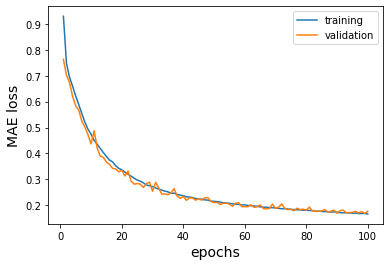

In [17]:
epochs = np.arange(1,len(ting['loss'])+1)

plt.plot(epochs,ting['loss'],label='training')
plt.plot(epochs,ting['val_loss'],label='validation')
plt.xlabel('epochs',fontsize=14)
plt.ylabel('MAE loss',fontsize=14)
plt.legend()
plt.savefig('RNNJF-loss-curve.png')

In [ ]:
epochs = np.arange(1,len(myRNN_hist.history['loss'])+1)

plt.plot(epochs,myRNN_hist.history['loss'],label='training')
plt.plot(epochs,myRNN_hist.history['val_loss'],label='validation')
plt.xlabel('epochs',fontsize=14)
plt.ylabel('MSE loss',fontsize=14)
plt.legend()

# Result Analysis

Section to produce plots to understand our RNN performance. Ultimately we want to understand how our RNN gets its results, and why it gets these particular results. E.g. is our performance limited by resolution, bad results due to one particular track, how do different displacements of the sec vertex affect performance, how do n of sec or tertiary tracks, ...


First we load the best performing model from its weights file

In [11]:
# load model
myRNN.load_weights('./bestRNN.h5')


Use the RNN now to predict the vertices of a test sample X_test. This is essentially 20000 jets, each jet consisting of its track collection (the first track in the collection is an artificial one consisting of the measured jet direction)

In [49]:
%%time
results=myRNN.predict(X_test)
results

Wall time: 16.3 s


array([[1.4857343 , 1.4862646 , 2.104029  , 1.7463042 , 1.740516  ,
        2.4720626 ],
       [1.5853068 , 1.5856559 , 2.2441018 , 1.8585669 , 1.9306494 ,
        2.6419601 ],
       [1.4931606 , 1.4938701 , 2.1149027 , 2.0120773 , 1.7698807 ,
        2.8708382 ],
       ...,
       [2.375138  , 2.3751917 , 3.360962  , 3.7921944 , 3.6204538 ,
        5.1514063 ],
       [0.29586148, 0.29628602, 0.41901588, 1.437701  , 1.3709806 ,
        1.2122166 ],
       [0.25751218, 0.25766087, 0.3642787 , 0.7288151 , 0.7197899 ,
        0.85807943]], dtype=float32)

In [ ]:
%%time

Xrando=copy.copy(X_test)

for i in range(len(X_test)):
    null_ind=np.where(Xrando[i]==0.)[0][0]
    np.random.shuffle(Xrando[i][0:null_ind])
    
results2 = myRNN.predict(Xrando)
percentage_errs=(abs((results-y_test)/y_test)*100) # average error of 50%, so for vtx at 1mm, we get within 0.5mm
mean_abs_errs = abs((results-y_test))
mae_per_jet = np.mean(mean_abs_errs,axis=1)

percentage_errs2=(abs((results2-y_test)/y_test)*100) # average error of 50%, so for vtx at 1mm, we get within 0.5mm
mean_abs_errs2 = abs((results2-y_test))
mae_per_jet2 = np.mean(mean_abs_errs2,axis=1)

In [50]:
percentage_errs=(abs((results-y_test)/y_test)*100) # average error of 50%, so for vtx at 1mm, we get within 0.5mm
mean_abs_errs = abs((results-y_test))
mae_per_jet = np.mean(mean_abs_errs,axis=1)

In [51]:
print(np.median(mae_per_jet)) 
print(np.mean(mae_per_jet))
# print(np.median(mae_per_jet2)) 
# print(np.mean(mae_per_jet2))

0.06431171933156808
0.11804502152656114


In [ ]:
plt.hist(mae_per_jet,bins='scott')
plt.show()
#plt.hist(mae_per_jet2,bins='scott')
#plt.show()

### Errors against Sec Vtx Displacement

Look at the percentage and absolute errors of jets in two regions. Regions separated by the absolute displacement of secondary (and tertiary) vertex, ds. Find a phase behaviour transition arond ds=1mm

In [ ]:
# separate out large ds jets
tervtx_cond = np.linalg.norm(bjets_DF[['terVtx_x','terVtx_y','terVtx_z']],axis=1)[split:] > 1.4/1000
secvtx_cond = np.linalg.norm(bjets_DF[['secVtx_x','secVtx_y','secVtx_z']],axis=1)[split:] > 1.4/1000
large_displaced_bs_indices= np.where(secvtx_cond & tervtx_cond)[0]
print("large ds mean % err",np.mean(percentage_errs[large_displaced_bs_indices]))
# so for jets where both sec and ter vtx are more than 1mm displaced, the percentage error is average 3% (and median 2%)
large_ds_perc_errs = np.mean(percentage_errs[large_displaced_bs_indices],axis=1)
large_ds_maes = mae_per_jet[large_displaced_bs_indices]


# now do same for small ds jets
tervtx_cond = np.linalg.norm(bjets_DF[['terVtx_x','terVtx_y','terVtx_z']],axis=1)[split:] < 1.5/1000
secvtx_cond = np.linalg.norm(bjets_DF[['secVtx_x','secVtx_y','secVtx_z']],axis=1)[split:] < 1.5/1000
small_displaced_bs_indices= np.where(secvtx_cond & tervtx_cond)[0]
print("small ds mean % err",np.mean(percentage_errs[small_displaced_bs_indices]))
small_ds_perc_errs = np.mean(percentage_errs[small_displaced_bs_indices],axis=1)
small_ds_maes = mae_per_jet[small_displaced_bs_indices]

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,8))

axs[0, 0].hist(large_ds_perc_errs,np.linspace(0,100,100))
axs[0, 0].set_ylabel('N ds>1mm jets')

axs[0, 1].hist(large_ds_maes,bins=np.linspace(0,1,100))

axs[1, 0].hist(small_ds_perc_errs,np.linspace(0,100,100))
axs[1, 0].set_xlabel('Mean % Error')
axs[1, 0].set_ylabel('N ds<1mm jets')

axs[1, 1].hist(small_ds_maes,bins=np.linspace(0,1,100))
axs[1, 1].set_xlabel('Mean Abs Error')


Look at one of the outlier cases, a large ds with the largest percentage error

In [ ]:
print(np.argmax(np.mean(percentage_errs[large_displaced_bs_indices],axis=1)))
argmaxind = np.argmax(np.mean(percentage_errs[large_displaced_bs_indices],axis=1))
actual_ind = large_displaced_bs_indices[argmaxind]
np.sqrt(bjets_DF.iloc[split+actual_ind]['secVtx_x']**2 + bjets_DF.iloc[split+actual_ind]['secVtx_y']**2 + bjets_DF.iloc[split+actual_ind]['secVtx_z']**2)
#np.linalg.norm(bjets_DF.iloc[split+1853]['secVtx_x','secVtx_y','secVtx_z'],axis=1)

### Vertexing Efficiency

Define a found vertex when a reconstructed vertex is within a specified tolerance distance of a true vertex. This tolerance is based off of the errors added at simulation level. So as a first estimate take if its within 5 sigma. Need to do some error analysis do this properly...

Make a very basic guess. Errors in theta, phi propagate as sigma x ds (ds is vtx displacement). IP errors propagate simply. So add all together it would be (sigma_ip + ds x sigma_ang) (careful with units). ds ranges between 1-10mm.
so error is approx (1.01 x sigma)m (as sigma_ip = sigma m, sigma_ang = sigma rad).

Remember to apply in the longitudinal and transverse directions separately. So calculate error in xy and error in z separately.

In [ ]:
reconstructed_vertices = results.reshape(40000,3)

In [ ]:
true_vertices = y_test.reshape(40000,3)

In [ ]:
err_in_z = (reconstructed_vertices-true_vertices)[:,2]
len(np.where(abs(err_in_z) < .05)[0])

As an initial estimate 16316/40000 (40.8%) vertices found using only criteria on the z, i.e. err_z < 0.05mm (5x10^-5 = 5xsigma_z)
But need to factor in the xy condition as well.

In [ ]:
x_x0 = (reconstructed_vertices-true_vertices)[:,0]
y_y0 = (reconstructed_vertices-true_vertices)[:,1]
err_in_xy = np.sqrt((x_x0)**2 + (y_y0)**2)
len(np.where(err_in_xy < .05)[0])

So a lot less pass the xy condition then the z condition. Only 14208/40000 (35.5%).

In [ ]:
len(np.where((err_in_xy < .05) & (abs(err_in_z) < .05))[0])

So 13087/40000 (32.7%) vertices found.

In [ ]:
len(np.where(err_in_xy + abs(err_in_z) < 0.1)[0])

In [ ]:
plt.hist(err_in_z,bins=np.linspace(-2,2,200))
plt.show()

In [ ]:
from scipy.stats import norm, cauchy
from sklearn.mixture import GaussianMixture

import matplotlib.mlab as mlab

In [ ]:
plt.figure(figsize=(10,8))
# best fit of data
(mu, sigma) = cauchy.fit(err_in_z)

# the histogram of the data
n, bins, patches = plt.hist(err_in_z, bins=np.linspace(-2,2,200),normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = cauchy.pdf( bins,mu, sigma)
l = plt.plot(bins, y, 'r--', label='lorentzian fit',linewidth=2)
plt.xlabel('error in z')
plt.ylabel('Normed Count')
plt.title(r'$\mathrm{Error\ in\ z\ for\ 1mm\ sample:\:}\ \mu=%.3f mm,\ \sigma=%.3f mm$' %(mu, sigma))
plt.grid(True)
plt.legend()

print(mu)
print(sigma)

In [ ]:
plt.figure(figsize=(10,8))
# best fit of data
(mu, sigma) = norm.fit(err_in_z[abs(err_in_z)<.2])

# the histogram of the data
n, bins, patches = plt.hist(err_in_z, bins=np.linspace(-2,2,300),normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', label='gaussian fit',linewidth=2)
plt.xlabel('error in z')
plt.ylabel('Normed Count')
plt.title(r'$\mathrm{Error\ in\ z\ for\ 0.1mm\ sample:\:}\ \mu=%.3f mm,\ \sigma=%.3f mm$' %(mu, sigma))
plt.grid(True)
plt.legend()

print(mu)
print(sigma)

In [ ]:
plt.figure(figsize=(10,8))
# best fit of data
gmm = GaussianMixture(n_components=2)
gmm.fit(err_in_z.reshape(-1,1))
mu1 = gmm.means_[0, 0]
mu2 = gmm.means_[1, 0]
var1, var2 = gmm.covariances_
wgt1, wgt2 = gmm.weights_

print(var1[0])
print(var2[0])

# the histogram of the data
n, bins, patches = plt.hist(err_in_z, bins=np.linspace(-2,2,300),normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = norm.pdf( bins, mu2, var2[0])
#l = plt.plot(bins, y, 'r--', label='gaussian fit',linewidth=2)
plt.plot(bins, norm.pdf(bins, mu1, np.sqrt(var1)).reshape(300))
plt.plot(bins, norm.pdf(bins, mu2, np.sqrt(var2)).reshape(300),'r')
#plt.plot(bins, norm.pdf(bins, mu1, np.sqrt(var1)).reshape(300)+norm.pdf(bins, mu2, np.sqrt(var2)).reshape(300))
plt.xlabel('error in z')
plt.ylabel('Normed Count')
plt.title(r'$\mathrm{Error\ in\ z\ for\ 0.1mm\ sample:\:}\ \mu1=%.3f mm,\ \sigma1=%.3f mm$' %(mu1, np.sqrt(var1[0])))
plt.grid(True)
plt.legend()

print(mu)
print(sigma)

In [ ]:
err_in_z[abs(err_in_z)<3]

### Impact of Tracks in a Jet

Use this "bootstrap" method. Remove a single track from a jet and use the RNN to predict on this new jet. Observe the new values of mean Abs err and mean % err. Loop through tracks in the jet and see if removing tracks can improve performance.

In [129]:
def plot_mpes_and_maes(x,y1,y2, title, yaxis, ignore_dir, rescale = 1):
    width = 0.35       # the width of the bars
    if ignore_dir:
        x=x[1:]
        y1=y1[1:]
        y2=y2[1:]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    rects1 = ax.bar(x, rescale*np.array(y1), width, color='royalblue')

    rects2 = ax.bar(x+width, y2, width, color='seagreen')

    # add some
    ax.set_ylabel(yaxis)
    ax.set_xlabel('Removed Track')
#     ax.set_title(title)
    #ax.set_xticks(x + width / 2)
    ax.legend( (rects1[0], rects2[0]), ('Sec Vtx', 'Ter Vtx') )

    plt.savefig(title+'.png')
    plt.show()

Now select a jet and calculate the delta errors for each track removal

In [130]:
def rm_one_track(jet_index,title='goodjettracks'):
    jet_copy = copy.copy(X_test[jet_index])
    original_prediction = myRNN.predict(np.array([jet_copy]))
    true_values = y_test[jet_index]

    original_abs_err = (original_prediction - true_values)
    original_mae = np.mean(original_abs_err)
    original_mpe = np.mean(100*original_abs_err/true_values)
    print(original_mae)

    #for sec and ter vtx separately
    original_sec_err = np.linalg.norm((original_prediction - true_values)[0,0:3])
    original_ter_err = np.linalg.norm((original_prediction - true_values)[0,3:])
    true_secvtx_distance_from0 = np.linalg.norm(true_values[:3]) 
    true_tervtx_distance_from0 = np.linalg.norm(true_values[3:]) 
    original_sec_perr = 100*(original_sec_err/true_secvtx_distance_from0)
    original_ter_perr = 100*(original_ter_err/true_tervtx_distance_from0)

    print(original_sec_err)
    print(original_ter_err)

    # find the first null track, as dif n of tracks in each jet
    for i in range(30):
        if not np.any(jet_copy[i]):
            null_trk_index = i
            break

    print(null_trk_index)

    # now to delete the jth track and add a null track at the end of the track_collection
    # to ensure there are still 30 tracks
    maes=[]
    mpes=[]
    sec_errs=[]
    sec_perrs=[]
    ter_errs=[]
    ter_perrs=[]
    for j in range(null_trk_index):
        actual_tracks = jet_copy[0:null_trk_index]
        jet_minus_trk=np.zeros((30,7))
        jet_minus_trk[0:null_trk_index-1] = np.delete(actual_tracks,j,0) # deletes the jth track
        new_prediction = myRNN.predict(np.array([jet_minus_trk]))

        #calculate delta err for sec and ter vertices separately
        new_sec_err = np.linalg.norm((new_prediction - true_values)[0,0:3])
        new_ter_err = np.linalg.norm((new_prediction - true_values)[0,3:])
        new_sec_perr = 100*(new_sec_err/true_secvtx_distance_from0)
        new_ter_perr = 100*(new_ter_err/true_tervtx_distance_from0)

        sec_errs.append(new_sec_err-original_sec_err)
        ter_errs.append(new_ter_err-original_ter_err)
        sec_perrs.append(new_sec_perr-original_sec_perr)
        ter_perrs.append(new_ter_perr-original_ter_perr)

    t = np.linspace(1,null_trk_index,null_trk_index)
    plot_mpes_and_maes(t, sec_errs, ter_errs,  title+"_err" , "Change in Error", ignore_dir = False)
    plot_mpes_and_maes(t, sec_perrs, ter_perrs, title+"_perr", "Change in % Error", ignore_dir = False)

-0.02525901151061986
0.09035980779328222
0.011158080797852025
8


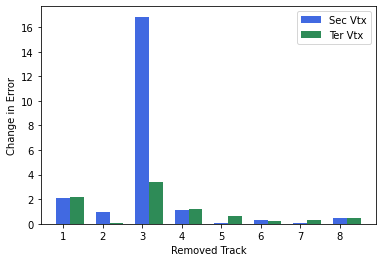

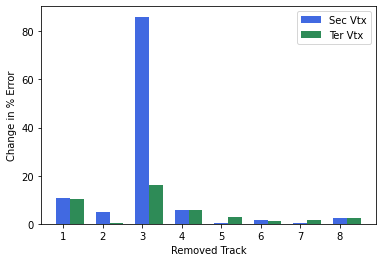

In [131]:
# jet_index = actual_ind
jet_index = 13568

rm_one_track(13568,'goodjettracks')

In [110]:
print(mae_per_jet[jet_index])
percentage_errs[jet_index]

0.028447596181772578


array([0.44352423, 0.4606002 , 0.47059994, 0.07789667, 0.01280583,
       0.04978114])

In [111]:
real_idx=np.where(y == y_test[jet_index])[0][0]
bjets_DF.iloc[real_idx]
# both i=2 and 3 are large IP tracks, both tertiary tracks but affect prediction of sec and ter vtx

jet_energy                                               88497.5
jet_flavour                                                    5
nSecTracks                                                     1
nTerTracks                                                     3
secVtx_x                                              0.00979032
secVtx_y                                              0.00979032
secVtx_z                                               0.0138456
terVtx_x                                               0.0105229
terVtx_y                                               0.0106848
terVtx_z                                               0.0149581
tracks         [[0.0009700036196528903, -0.000116567274194510...
Name: 80059, dtype: object

In [112]:
X_allfeatures[real_idx]

array([[ 1.49722799e-03,  1.66943618e-03,  8.37636796e-01,
         8.87060391e-01,  1.13699142e-04,  1.05229119e-02,
         1.06848099e-02,  1.49580689e-02, -4.02750232e-04,
        -1.44204157e-03,  1.66943618e-03],
       [ 1.52404471e-03,  1.26498599e-03,  8.65168355e-01,
         8.63319040e-01,  4.20551158e-04,  1.05229119e-02,
         1.06848099e-02,  1.49580689e-02,  1.28873233e-04,
        -1.51858618e-03,  1.26498599e-03],
       [ 1.86553362e-03, -3.91941848e-04,  9.14299138e-01,
         7.55572205e-01,  5.75051447e-05,  1.05229119e-02,
         1.06848099e-02,  1.49580689e-02,  1.69684260e-03,
        -7.75203770e-04, -3.91941848e-04],
       [ 9.70003620e-04, -1.16567274e-04,  7.16551240e-01,
         7.75261784e-01,  2.37021305e-05,  9.79031535e-03,
         9.79031535e-03,  1.38455967e-02, -5.36368576e-04,
         8.08217652e-04, -1.16567274e-04],
       [ 1.05511176e-05, -2.08957798e-05,  8.10058940e-01,
         7.85097912e-01,  1.71946777e-04,  0.00000000e+00,
  

0.1589673679980351
0.29183723978328413
0.266666886517678
10


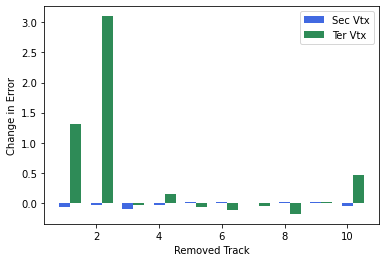

<Figure size 432x288 with 0 Axes>

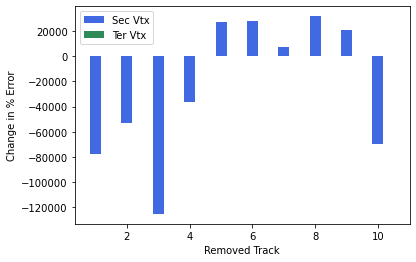

<Figure size 432x288 with 0 Axes>

In [113]:
# jet_index = actual_ind
jet_index = 1618
rm_one_track(jet_index,'badjettracks')

In [114]:
print(mae_per_jet[jet_index])
percentage_errs[jet_index]

0.1589672537557993


array([3.72822697e+05, 3.78583123e+05, 3.90247641e+05, 2.52148680e+00,
       2.70426329e+00, 1.28869813e+00])

In [65]:
real_idx=np.where(y == y_test[jet_index])[0][0]
bjets_DF.iloc[real_idx]
# both i=2 and 3 are large IP tracks, both tertiary tracks but affect prediction of sec and ter vtx

jet_energy                                                 70200
jet_flavour                                                    5
nSecTracks                                                     3
nTerTracks                                                     3
secVtx_x                                              3.8094e-08
secVtx_y                                              3.8094e-08
secVtx_z                                              5.3873e-08
terVtx_x                                              0.00606375
terVtx_y                                              0.00660532
terVtx_z                                              0.00976203
tracks         [[1.628684627349816e-05, 2.0908664678629624e-0...
Name: 259071, dtype: object

-0.017863942525476628
0.10858618456673394
0.054466693941440034
10


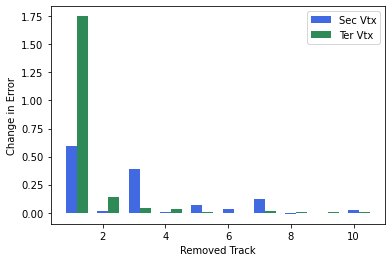

<Figure size 432x288 with 0 Axes>

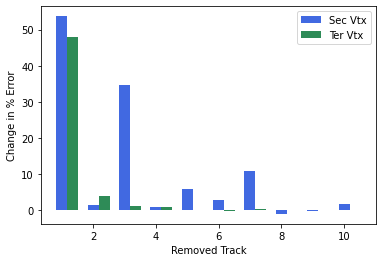

<Figure size 432x288 with 0 Axes>

In [115]:
# jet_index = actual_ind
jet_index = 1234

rm_one_track(jet_index, 'randojettracks')

In [116]:
print(mae_per_jet[jet_index])
percentage_errs[jet_index]

0.04388304243056196


array([9.71464152, 9.67650187, 9.77234664, 0.6909151 , 2.9189434 ,
       0.53175421])

In [117]:
real_idx=np.where(y == y_test[jet_index])[0][0]
bjets_DF.iloc[real_idx]
# both i=2 and 3 are large IP tracks, both tertiary tracks but affect prediction of sec and ter vtx

jet_energy                                               61815.9
jet_flavour                                                    5
nSecTracks                                                     2
nTerTracks                                                     4
secVtx_x                                             0.000557763
secVtx_y                                             0.000557763
secVtx_z                                             0.000788797
terVtx_x                                              0.00198787
terVtx_y                                              0.00174698
terVtx_z                                              0.00250678
tracks         [[0.00013675219407009565, 9.590873898436198e-0...
Name: 235400, dtype: object

In [ ]:
tes=np.array([jet_copy])
tes2=tes[:,:11]
np.random.shuffle(tes2[0])
tes[:,:11]=tes2
myRNN.predict(tes)

In [ ]:
myRNN.predict(np.array([jet_copy]))

In [ ]:
myRNN.predict(np.zeros((1,30,5)))

Maybe if I looked into histograming the above sec_maes. Problem is for one jet theres not really enough statistics, you'd need to do it across jets, but then have to account for confounders, treat them as nuisance params and integrate out. E.g. momentum, decay position etc. Bring in the fact that % and abs are dif

### Error Change as tracks added

Idea is to plot the MAE and MPE of a jet adding in each track one by one. So start with all null tracks, then add track 1 (the direction), track 2, track 3, ...
Look at the curve MAE, look for changes.
Again do for sec and ter vtx separately.

In [119]:
jet_index=13568


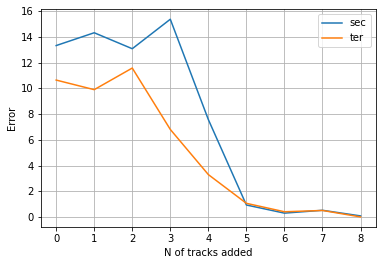

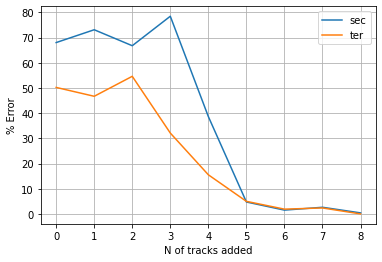

In [125]:
jet_copy = copy.copy(X_test[jet_index])
true_values = y_test[jet_index]

#for sec and ter vtx separately
blank_jet = np.zeros((1,30,7))

blank_prediction = myRNN.predict(blank_jet)

blank_sec_err = np.linalg.norm((blank_prediction - true_values)[0,0:3])
blank_ter_err = np.linalg.norm((blank_prediction - true_values)[0,3:])
true_secvtx_distance_from0 = np.linalg.norm(true_values[:3]) 
true_tervtx_distance_from0 = np.linalg.norm(true_values[3:]) 
blank_sec_perr = 100*(blank_sec_err/true_secvtx_distance_from0)
blank_ter_perr = 100*(blank_ter_err/true_tervtx_distance_from0)


sec_errs=[blank_sec_err]
sec_perrs=[blank_sec_perr]
ter_errs=[blank_ter_err]
ter_perrs=[blank_ter_perr]

for i in range(30):
    if not np.any(jet_copy[i]):
        null_trk_index = i
        break


for i in range((null_trk_index)):
    blank_jet[0,i] = jet_copy[i]
    
    new_prediction = myRNN.predict(blank_jet)
    
    #calculate delta err for sec and ter vertices separately
    new_sec_err = np.linalg.norm((new_prediction - true_values)[0,0:3])
    new_ter_err = np.linalg.norm((new_prediction - true_values)[0,3:])
    new_sec_perr = 100*(new_sec_err/true_secvtx_distance_from0)
    new_ter_perr = 100*(new_ter_err/true_tervtx_distance_from0)

    sec_errs.append(new_sec_err)
    ter_errs.append(new_ter_err)
    sec_perrs.append(new_sec_perr)
    ter_perrs.append(new_ter_perr)
    
trk_n = np.linspace(0,null_trk_index,null_trk_index+1)
plt.plot(trk_n, sec_errs, label ='sec')
plt.plot(trk_n, ter_errs, label ='ter')
plt.legend()
plt.grid(which='major')
plt.ylabel("Error")
plt.xlabel("N of tracks added")
plt.savefig('goodjet_err_over_time.png')

plt.show()
plt.plot(trk_n, sec_perrs, label ='sec')
plt.plot(trk_n, ter_perrs, label='ter')
plt.ylabel("% Error")
plt.xlabel("N of tracks added")
plt.legend()
plt.grid(which='major')
plt.savefig('goodjet_perr_over_time.png')

plt.show()

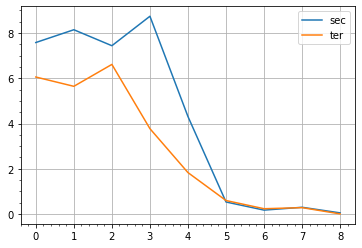

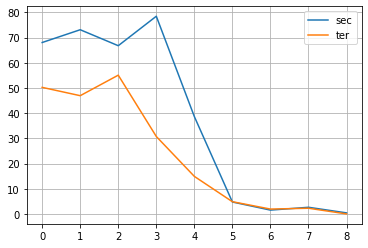

### Plot of errors for each value

Plots all the individual (secondary x, secondary y, secondary z, tertiary x...) % errors, the distribution looks gaussian with a very long tail

In [ ]:
percerrs=percentage_errs.reshape(120000)# plot distribution of mean errs per jet

plt.hist((percerrs), bins=np.linspace(0,50,100))#90,100,200,300,400,500,600,700,800,900])
plt.xlabel('% errors in sec and ter xyz')

#plt.hist((meanerrs), bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])


In [ ]:
mean_perc_err_per_jet=np.mean(percentage_errs,axis=1)

In [ ]:
print(np.median(mae_per_jet)) # median error is 7% that's actually not too bad considering gauss err of 1% on 5 params (ish)
print(np.mean(mae_per_jet)) # mean and median very different

### Bad jet analysis

Idea here to analyse the worse performing jets. Difficulty is defining bad performance. I've done this by combining bad absolute and percentage error (see below). Unfortunately also means we are looking at the tail of performance (only about 2% jets)

In [ ]:
print(len(mae_per_jet[mae_per_jet > .5])/20000, "of jets mean absolute errors above .5")

In [ ]:
badjets=np.where(mae_per_jet > .5)


In [ ]:
plt.hist(mae_per_jet[badjets],bins='scott')

In [ ]:
# here's  a particular bad jet
jet=badjets[0][0]
print("this bad jet has a mean % err",mean_perc_err_per_jet[jet])
print("this bad jet has a mean abs err",mae_per_jet[jet])

In [ ]:
y_test[jet]

In [ ]:
results[jet]

Now we loop over our worst jets, define these as having an abs err > 0.2mm and percentage error > 10%. We then look at the parameters of these bad jets, e.g. phi, theta, momentum, n of sec tracks, n of ter tracks, phis of the sec tracks (this last is moving towards the idea of examining the individual tracks in worst performing jets)

In [ ]:
indices=280000+np.where(np.logical_and(mae_per_jet > .2, mean_perc_err_per_jet> 10.))[0] # 0.2 is pretty arbitrary, 0.2 for a jet with 20mm sec vtx is actually good
print("we have "+str(len(indices))+" bad jets")
bad_phis=[]
bad_thetas=[]
bad_1OverP=[]
bad_sectrkphis=[]
bad_nSecTrks=[]
bad_nTerTrks=[]

bad_sumSecTerTrks=[]

for index in indices:
    # extracts all the phi values of worst performing jets
    bad_phis.append(abs(bjets_DF.iloc[index]['tracks'][0][2]))
    bad_thetas.append(abs(bjets_DF.iloc[index]['tracks'][0][3]))
    bad_1OverP.append(abs(bjets_DF.iloc[index]['tracks'][0][4]))
    bad_sectrkphis.append(abs(bjets_DF.iloc[index]['tracks'][1][3]))
    bad_nSecTrks.append(bjets_DF.iloc[index]['nSecTracks'])
    bad_nTerTrks.append(bjets_DF.iloc[index]['nTerTracks'])

    bad_sumSecTerTrks.append(bjets_DF.iloc[index]['nSecTracks'] + bjets_DF.iloc[index]['nTerTracks'])


Below I plot the phis of sec tracks in badjets and the thetas of the the bad jets, the latter is just pi/4 as we fixed to this direction in simulation. I have suppressed the output here with %%capture as its is not instructive

In [ ]:
%%capture
plt.hist(bad_sectrkphis,bins=np.linspace(0.,3.2,65))
plt.axvline(x=np.pi/2, color='r', linestyle='dashed', linewidth=2)
plt.show()

plt.hist(bad_thetas,bins=np.linspace(0.,3.2,65))
plt.axvline(x=np.pi/2, color='r', linestyle='dashed', linewidth=2)


More plots, first let us plot the momentum distribution of the bad jets. Higher momentum jets have more displaced vertices and thus higher absolute errors. Lower momentum jets conversely have higher percentage errors due to resolution limits.

In [ ]:
#plt.hist(bad_1OverP,bins=np.linspace(0.,3.2,65))
bad_ps=np.reciprocal(bad_1OverP)
plt.hist(bad_ps,bins='scott')


Next look at the (true) number of secondary and tertiary tracks in the bad jets

In [ ]:
plt.hist(bad_nSecTrks, bins=[1,2,3,4])


In [ ]:
plt.hist(bad_nTerTrks, bins=[2,3,4,5,])
plt.show()
#plt.hist(bjets_DF['nTerTracks'], bins=[2,3,4,5])

The bad jets tend to have more tertiary tracks? Or is there not enough stats to say this.

In [ ]:
#plot the ntertracks in good jets now!!

# Jet Drawings

Here we have the code to plot the images of jets. Useful for looking at particular bad jets.

In [ ]:
def get_line_from_tp(track):
    p1 = track[5:8]
    print(p1)
    phi = track[2]
    theta = track[3]
    t = np.linspace(-.005,.005,100)
    
    xs = p1[0] + t * np.sin(theta) * np.cos(phi)
    ys = p1[1] + t * np.sin(theta) * np.sin(phi)
    zs = p1[2] + t * np.cos(theta)
    
    return xs, ys, zs

def get_line_using_IPs(track, zoom):
    phi = track[2]
    theta = track[3]
    x0 = track[0]*np.cos(phi)
    y0 = track[0]*np.sin(phi)
    z0 = track[1]
    p1 = np.array([x0,y0,z0])
    #print(p1)

    t = np.linspace(zoom[0],zoom[1],100)
    
    xs = p1[0] + t * np.sin(theta) * np.cos(phi) # array of x points
    ys = p1[1] + t * np.sin(theta) * np.sin(phi)
    zs = p1[2] + t * np.cos(theta)
    
    return xs, ys, zs

In [ ]:
def from_index_extract_tracks_and_vertices(jet_index,split,trks,bjets_DF,results):
    
    full_df_index = split+jet_index
    jet_tracks = trks[full_df_index]
    prim_vertex = np.array([0,0,0])
    sec_vertex = bjets_DF[['secVtx_x','secVtx_y','secVtx_z']].iloc[full_df_index].values
    ter_vertex = bjets_DF[['terVtx_x','terVtx_y','terVtx_z']].iloc[full_df_index].values
    true_vertices =np.array([prim_vertex,sec_vertex,ter_vertex])
    rec_vertices = results[jet_index].reshape(2,3)/1000
    
    return jet_tracks, true_vertices, rec_vertices

In [ ]:
def plot_jet(jet_tracks, true_vertices, rec_vertices, zoom=[-0.005,.01]):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    
    #plot the tracks
    for i,track in enumerate(jet_tracks):
        if i == 0: #jet direction
            xs, ys, zs = get_line_using_IPs(track, zoom)
            xs,ys,zs= 2*xs,2*ys,2*zs
            ax.plot(xs,ys,zs,'--')
        else:
            if not np.isnan(track[0]):
                xs, ys, zs = get_line_using_IPs(track, zoom)
                ax.plot(xs,ys,zs)

    #plot the true vertices
    for x, y, z in true_vertices:
        #print(x,y,z)
        ax.scatter(x, y, z, color='black', marker='s')
        
    # plot the reconstructed vertices
    for x, y, z in rec_vertices:
        #print(x,y,z)
        ax.scatter(x, y, z, color='red', marker='x')

In [ ]:
good_maes=np.where(mae_per_jet < .01)
good_maes

In [ ]:
bad_maes=np.where(mae_per_jet > 2.)
bad_maes

In [ ]:
%matplotlib inline
goodindex = 7247
badindex = 4712

zoom = [-0.001,0.004]
#print("good")
jet_tracks, true_vertices, rec_vertices = from_index_extract_tracks_and_vertices(goodindex, split,trks,bjets_DF,results)
plot_jet(jet_tracks, true_vertices, rec_vertices,[-0.0001,0.003])
#print("bad")


In [ ]:
%matplotlib inline

jet_tracks, true_vertices, rec_vertices = from_index_extract_tracks_and_vertices(badindex, split,trks,bjets_DF,results)
plot_jet(jet_tracks, true_vertices, rec_vertices,[-0.001,0.005])

In [ ]:
print(bjets_DF.iloc[goodindex+split])
print("\nand the bad\n")
print(bjets_DF.iloc[badindex+split])


In [ ]:
mean_err_per_jet[bad_maes]

In [ ]:
bad_maes

In [ ]:
np.where(mean_err_per_jet[good_maes]>100.)


In [ ]:
good_maes[0][96]

In [ ]:
mean_err_per_jet[15683]

In [ ]:
def my_dummy_func(blabla):
    blabla += 1
    return sec_dummy_func(blabla)
    
def sec_dummy_func(blabla2):
    if blabla2 == 1:
        boolean = False
        integer = 1
        return boolean, integer
    else:
        boolean = True
        integer = 2
        return boolean

In [ ]:
my_dummy_func(0)

In [ ]:
my_dummy_func(2)